In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100

def show(df):
    for j in df.index:
        print(j)
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
        X = grid_of_images_default(X)
        imsave('out.png', X)
        im = Image('out.png')
        display(im)
db = load_db()

In [5]:
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
        
    for k, v in j['stats'].items():
        col[k] = v

    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    

    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    col['digits_object'] = 1 - col['digits_entropy']
    col['letters_object'] = 1 - col['letters_entropy']
    col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    col['emnist_object'] = 1 - col['emnist_letters_entropy']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')
df_full.to_csv('hypers.csv')

## Fix stride. vary nb of layers

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==2]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## Fix nb layers. Vary stride

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

In [ ]:
show(df)

# wta lifetime sparsity

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_lifetime']
df = df[df['zero_ratio']==0.7]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## wta kchannel

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df = df[df['noise'] < 0.6]
show(df)

In [ ]:
df.plot('noise', ['digits_count'])

In [ ]:
from IPython.display import Image
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

In [ ]:
x = df_full[['nb_layers', 'bottleneck', 'stride', 'zero_ratio', 'noise']].fillna(-1)
y = 20 * df_full['letters_count'] + df_full['letters_objectness']

In [ ]:
import scikitplot as pl
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x, y)
reg.feature_importances_ = reg.coef_
pl.estimators.plot_feature_importances(reg, feature_names=x.columns)

In [ ]:
df_full.plot('emnist_letters_count', 'emnist_objectness', kind='scatter')

In [ ]:
d = df_full.copy()
#d['y'] = d['emnist_letters_count']
d['y'] =  d['emnist_letters_count'] + 5*d['emnist_object'] + 10*d['letters_diversity']
#d['y'] =  30*d['emnist_digits_count'] + d['emnist_objectness']
#d['y'] = d['letters_objectness']
d = d.sort_values(by='y', ascending=False)
show(d.iloc[0:10])

In [7]:
labels = [
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'digits_object',
    'letters_object'
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,digits_object,letters_object
digits_count,1,-0.897334,0.504346,0.410802,0.0418502,0.47685,0.722219,0.733846
letters_count,-0.897334,1,-0.420536,-0.322768,0.0374954,-0.395098,-0.58721,-0.580033
digits_objectness,0.504346,-0.420536,1,0.921371,0.716197,0.956652,0.716653,0.741885
letters_objectness,0.410802,-0.322768,0.921371,1,0.832285,0.957296,0.663214,0.716624
digits_and_letters_objectness,0.0418502,0.0374954,0.716197,0.832285,1,0.74305,0.515915,0.575556
emnist_objectness,0.47685,-0.395098,0.956652,0.957296,0.74305,1,0.680918,0.709819
digits_object,0.722219,-0.58721,0.716653,0.663214,0.515915,0.680918,1,0.943948
letters_object,0.733846,-0.580033,0.741885,0.716624,0.575556,0.709819,0.943948,1


In [13]:
d.columns

Index(['bottleneck', 'digits_and_letters_entropy', 'digits_and_letters_object',
       'digits_and_letters_objectness', 'digits_count', 'digits_diversity',
       'digits_entropy', 'digits_frechet', 'digits_max', 'digits_mmd',
       'digits_object', 'digits_objectness', 'emnist_digits_count',
       'emnist_digits_max', 'emnist_letters_count', 'emnist_letters_entropy',
       'emnist_letters_max', 'emnist_object', 'emnist_objectness',
       'hwrt_diversity', 'hwrt_entropy', 'hwrt_objectness', 'letters_count',
       'letters_diversity', 'letters_entropy', 'letters_frechet',
       'letters_max', 'letters_mmd', 'letters_object', 'letters_objectness',
       'nb_layers', 'nb_params', 'noise', 'noise_count', 'sampler', 'stride',
       'zero_ratio'],
      dtype='object')

/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


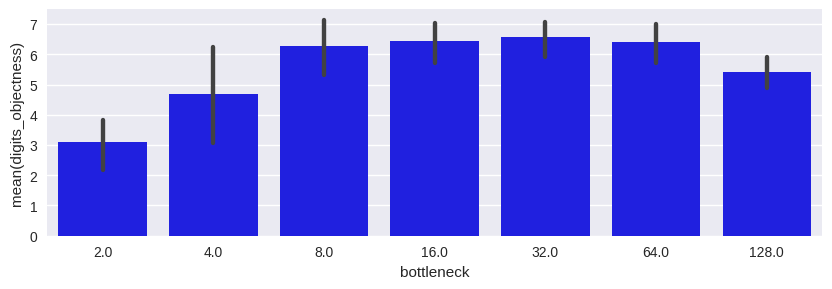

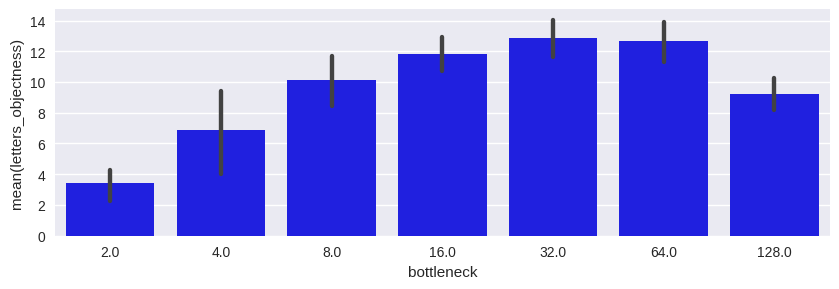

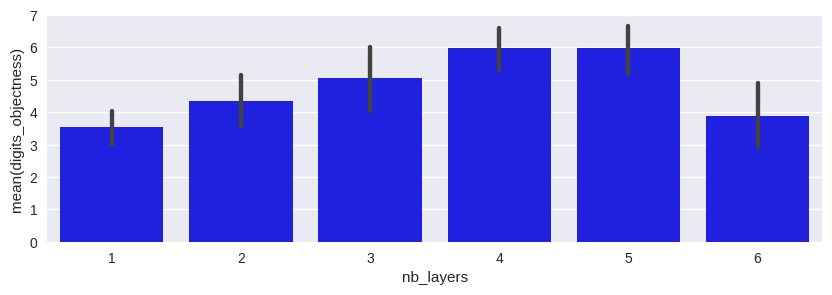

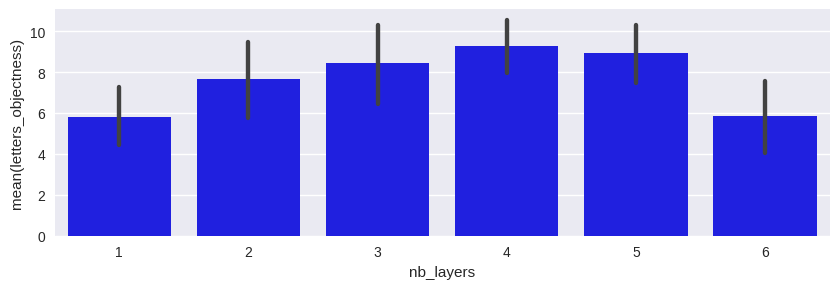

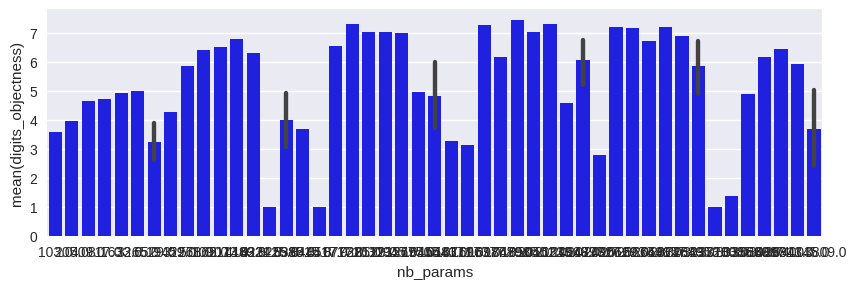

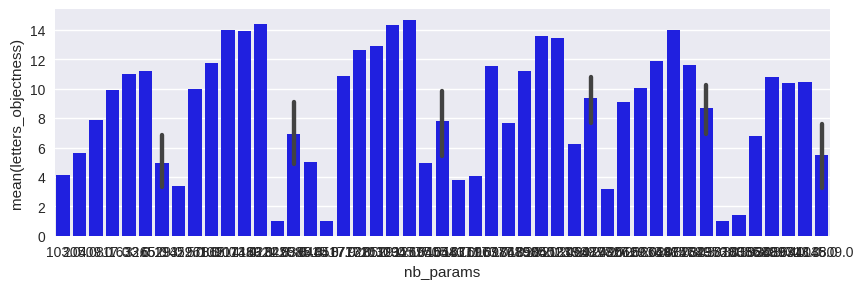

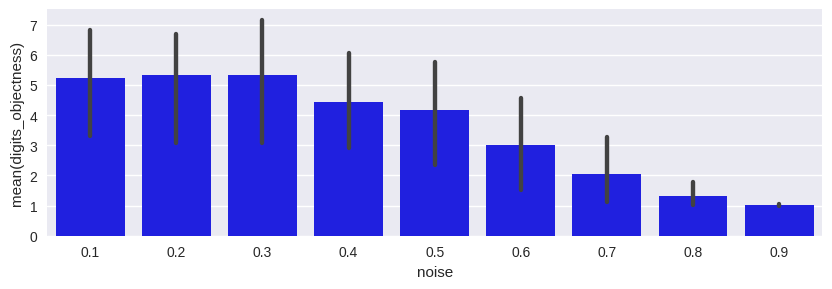

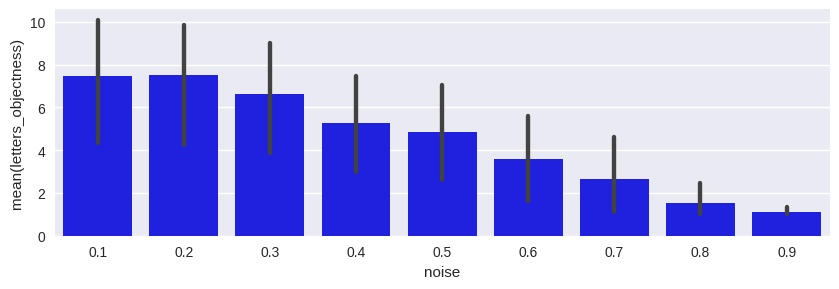

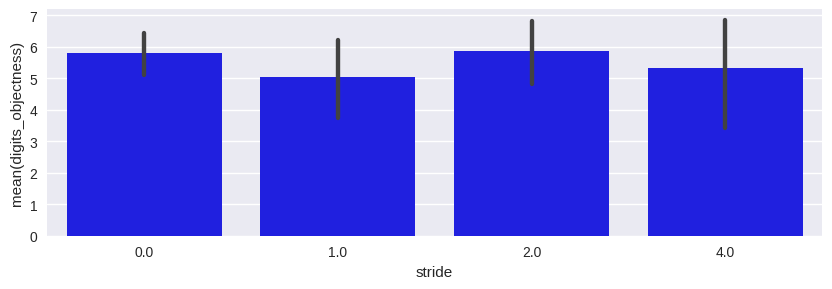

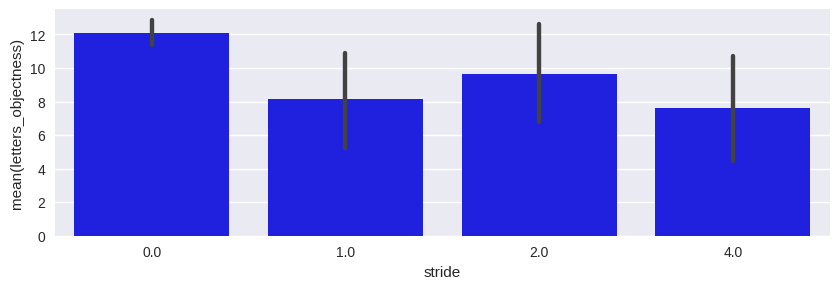

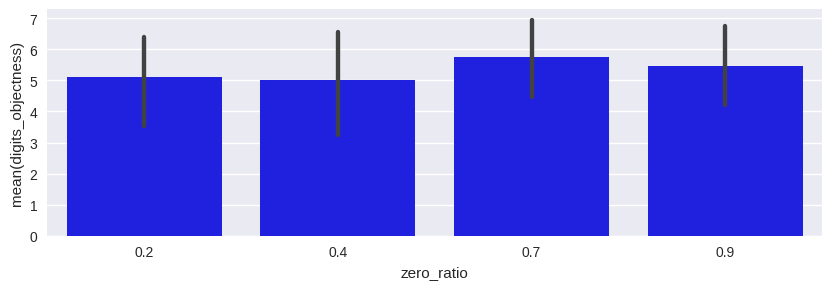

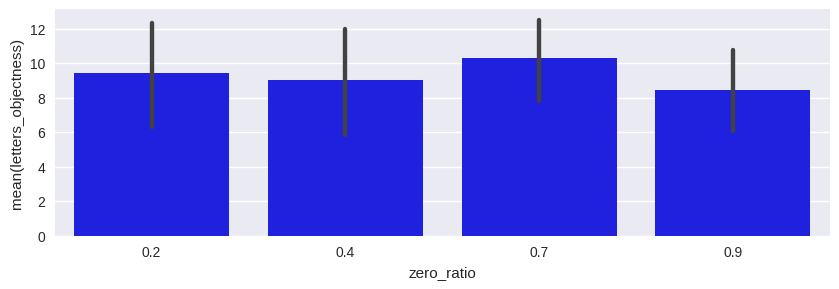

In [68]:
d = df_full
#d = df_full.fillna(-1)
#d = d[d['sampler']  == 'mnist_capacity']
ycols = ['digits_objectness' , 'letters_objectness']
xcols = ['bottleneck', 'nb_layers', 'nb_params', 'noise', 'stride', 'zero_ratio']
for xcol in xcols:
    for ycol in ycols:
        fig = plt.figure(figsize=(10, 3))
        sns.barplot(x=xcol, y=ycol, data=d, color='blue')
        plt.show()

2e0031950a7ade7c0a90fe957787e64b
04c1617e4181a6eb902d4299907d154e
5c5bf9994c2b1ba4d86540bb8f9c3091
f7a80edd7d1c9c90515651e3e86798d4
cf34fddfc38e4eed28e73fcffa2f7066
3feaca46d743469cc7696a3404e37031
e9f2476cf72c178bf5fa17b029b86dea
cd3d3b694a2fdf5938103feb39534e7d
ba180701c3c58a4de3f48662b850dc90
fcfe73728bc4338ad48a0487eca9bd9c
job_id
2e0031950a7ade7c0a90fe957787e64b    8.469911
04c1617e4181a6eb902d4299907d154e    8.332106
5c5bf9994c2b1ba4d86540bb8f9c3091    7.829299
f7a80edd7d1c9c90515651e3e86798d4    7.822666
Name: digits_objectness, dtype: float64
2e0031950a7ade7c0a90fe957787e64b


/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


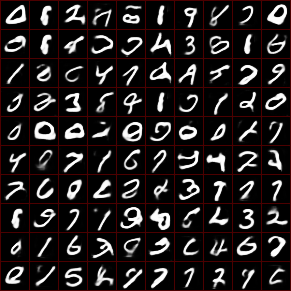

04c1617e4181a6eb902d4299907d154e


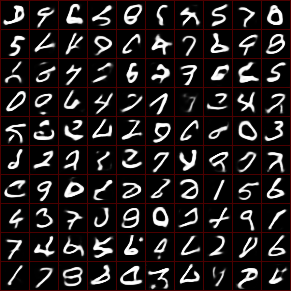

5c5bf9994c2b1ba4d86540bb8f9c3091


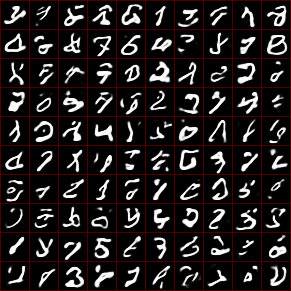

f7a80edd7d1c9c90515651e3e86798d4


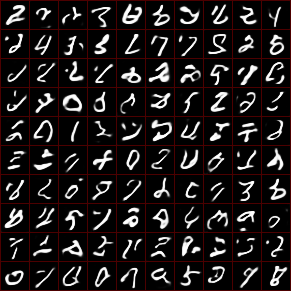

In [88]:
d = df_full
d = d.sort_values(by='digits_objectness', ascending=False)
for i in d.index[0:10]:
    print(i)
print(d['digits_objectness'].iloc[0:4])
show(d.iloc[0:4])

cf34fddfc38e4eed28e73fcffa2f7066
f316dedd30ebc5f51c4678f07979436c
7e7632c0f86786bda97931c4e88bbfd7
4a4b3a3a4562d7102aceb49eab12c8c0
901dad8ec11f23191d86fa6279d47c65
a167259933f54183c717cd4ed0529081
b75919e611b9c6ed0f063749d17ad699
68adffea6c98fedf329644122d56fa36
89a3e761400f676a40eb6cbc7cef391a
d8fd724967c9d8275c94886f01ac1ae2
job_id
cf34fddfc38e4eed28e73fcffa2f7066    14.936293
f316dedd30ebc5f51c4678f07979436c    14.877086
7e7632c0f86786bda97931c4e88bbfd7    14.681621
4a4b3a3a4562d7102aceb49eab12c8c0    14.428025
Name: letters_objectness, dtype: float64
cf34fddfc38e4eed28e73fcffa2f7066


/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


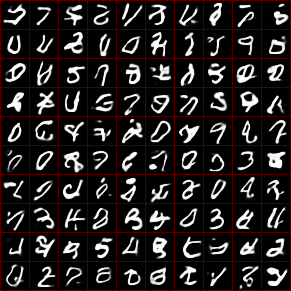

f316dedd30ebc5f51c4678f07979436c


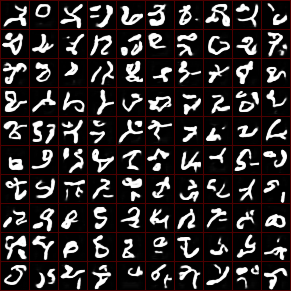

7e7632c0f86786bda97931c4e88bbfd7


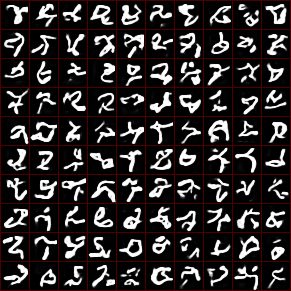

4a4b3a3a4562d7102aceb49eab12c8c0


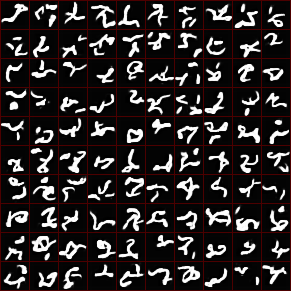

In [89]:
d = df_full
d = d.sort_values(by='letters_objectness', ascending=False)
for i in d.index[0:10]:
    print(i)
print(d['letters_objectness'].iloc[0:4])
show(d.iloc[0:4])